In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom, ks_2samp
from scipy import stats, linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from tqdm.auto import tqdm

c:\Users\joshu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 66/66 [00:08<00:00,  8.08it/s]


<Figure size 1000x1000 with 0 Axes>

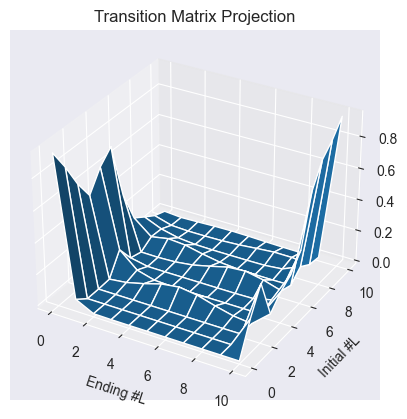

100%|██████████| 66/66 [00:06<00:00, 10.46it/s]


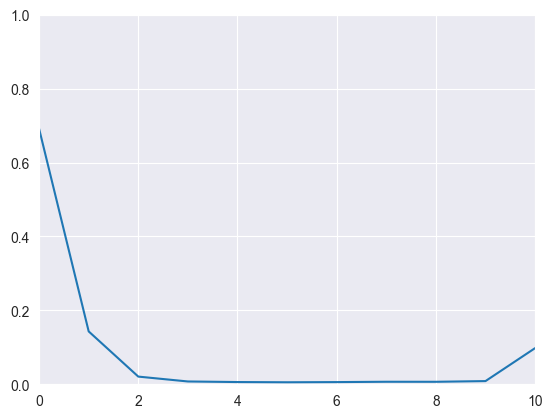

<Figure size 1000x1000 with 0 Axes>

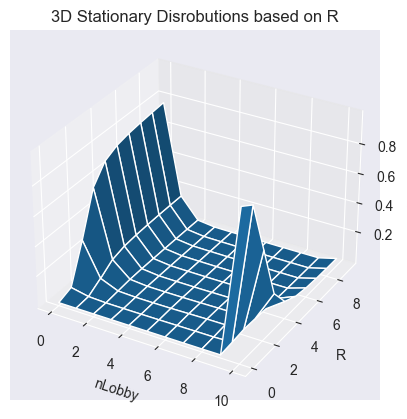

In [3]:
from ipynb.fs.full.BoringTM import *

In [4]:
## Base parameters
"""
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 10 ## Mean Fee of Getting Caught
nPPL = 11
fR = .25
R = nPPL * fR # enforcement resources

LobH = [2] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset
"""

'\nLC = 1 ## Lobby Cost\nT = 10 ## Tax\nmF = 10 ## Mean Fee of Getting Caught\nnPPL = 11\nfR = .25\nR = nPPL * fR # enforcement resources\n\nLobH = [2] ## Lobby History, arbitrary preset\nCatH = [1] ## Catch history, arbitrary preset\n'

In [5]:
def pSS1(LobH, CatH, nPPL, fR): #Gets probability of lobbying successfully, subjective
    t = len(LobH) - 1
    pss = 1 - ((.8+CatH[t]) / (1+LobH[t]))
    #print(pss)
    return pss

In [6]:
def pCat(LobH, nPPL, fR):  #Gets objective probability of success 
    R = nPPL * fR
    t = len(LobH) - 1
    if LobH[t] <= R:
  #      print(.8)
        return .8
    else:
 #       print(.8 * (R / LobH[t]))
        return .8 * (R / LobH[t])

In [7]:
def it(LobH, CatH, LC, T, mF, nPPL, fR):
    t = len(LobH)
    ps = pSS1(nPPL = nPPL, fR = fR, LobH = LobH, CatH = CatH)
    LobH.append(0)
    CatH.append(0)
    for i in range(0,nPPL+1):
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (np.random.normal(loc = mF, scale = 1)))):
            LobH[t] = LobH[t] + 1
            
    for i in range(0,LobH[t]):
        if random.random() < pCat(nPPL = nPPL, fR = fR, LobH = LobH):
            CatH[t] = CatH[t] + 1

In [8]:
def run(itr, LobH, CatH, LC, T, mF, nPPL, fR):
    for i in tqdm(range(0,itr)):
        it(LobH = LobH, CatH = CatH, LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)

In [9]:
def set(LC, T, mF, nPPL, fR, itr):
    LobH = [randint(0,nPPL)] ## Lobby History, arbitrary preset
    CatH = [randint(0,LobH[0])] ## Catch history, arbitrary preset
    run(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr, LobH = LobH, CatH = CatH)
    return LobH, CatH

In [10]:
LobH, CatH = set(LC = 1, T = 5, mF = 2, nPPL = 100, fR = .5, itr = 1000)


100%|██████████| 1000/1000 [00:00<00:00, 2810.21it/s]


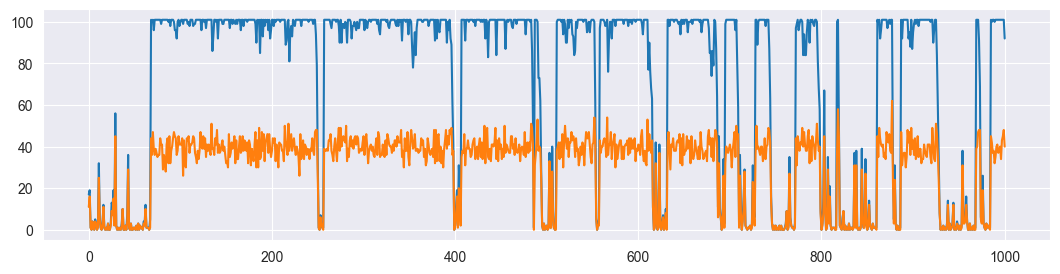

In [11]:
plt.figure(figsize=(13, 3)) 
plt.plot(LobH)
plt.plot(CatH)


In [12]:
#plt.hist(LobH, range = [0,nPPL+1])

In [13]:
def DynPDF(LC, T, mF, nPPL, fR, itr):
    MAXitr = itr
    itr = 10
    LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    count, bins_count = np.histogram(LobH, bins=nPPL+1)
    pdf2 = count / sum(count) 
    diff = 1

    while diff > .01 and itr <= MAXitr:
        itr = itr * 10
        pdf = pdf2
        LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
        count, bins_count = np.histogram(LobH, bins=nPPL+1)
        pdf2 = count / sum(count)
        diff = sum(abs(pdf - pdf2))
        n = 0
        while diff < .01 and n < 4:
            n = n + 1
            LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
            count, bins_count = np.histogram(LobH, bins=nPPL+1)
            pdf2 = count / sum(count)
            diff = sum(abs(pdf - pdf2))
        #if itr >= MAXitr: break
    #cdf = np.cumsum(pdf) 
    #nL = range(0,nPPL+1) # equals to list(set(words))
    #Lfreq = [x/(len(LobH)) for x in list(Counter(LobH).values())] # counts the elements' frequency
    pdf = pdf2   
    print(f"Stationary at {itr} iterations")
    return pdf, bins_count

In [14]:
DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 10, itr = 100000)[0]

100%|██████████| 1000000/1000000 [00:27<00:00, 36957.91it/s]


Stationary at 1000000 iterations


array([4.75728524e-01, 3.24889675e-02, 2.84999715e-03, 1.38999861e-03,
       7.35999264e-04, 3.60999639e-04, 2.71999728e-04, 2.47999752e-04,
       6.40999359e-04, 2.69999730e-03, 4.82584517e-01])

In [15]:
DPDF = DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 30, itr = 1000)[0]
pBin = 0
for i in range(0,5+1):
    pBin = pBin + DPDF[i]
pBin


100%|██████████| 10000/10000 [00:00<00:00, 13031.07it/s]

Stationary at 10000 iterations


9.999000099990002e-05

In [16]:
def ConvTEST(LC, T, mF, nPPL, fR, itr):
       DPDF = DynPDF(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr)[0]
       TMPDF = CollapsedSD(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL)
       print(DPDF)
       print(TMPDF)
       diff = sum(abs(DPDF - TMPDF))
       print(f"Differnece is : {diff}")
       if diff < .01: print("Yay")
       else: print("sucks to suck")

In [17]:
ConvTEST(LC = 1, T = 5, mF = 2, nPPL = 10, fR = .5, itr = 1000000)

100%|██████████| 1000000/1000000 [00:26<00:00, 38139.65it/s]


Stationary at 1000000 iterations


100%|██████████| 66/66 [00:07<00:00,  8.73it/s]

[0.62232938 0.14020686 0.02132798 0.00760099 0.00679899 0.00694599
 0.00671299 0.00587199 0.00598199 0.00907199 0.16715083]
[0.69126976 0.14300654 0.02077306 0.00759721 0.00602812 0.00541458
 0.00590404 0.00681254 0.0067278  0.00862718 0.09783917]
Differnece is : 0.1468528214944263
sucks to suck


In [18]:
TMPDF = [.1,.2,.3,.2,.1,.1]
TMPDF2 = [.3,.2,.2,.1,.1,.1]
cdf = np.cumsum(TMPDF)
cdf
#stats.kstest(TMPDF, TMPDF2)
ks_2samp(TMPDF, TMPDF2)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.1, statistic_sign=1)

In [19]:
def GraphDynPDF(LC, T, mF, nPPL, fR, itr):
    pdf, bins_count = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.ylim([0, 1])
    plt.legend()

100%|██████████| 100000/100000 [00:02<00:00, 38561.93it/s]


Stationary at 100000 iterations


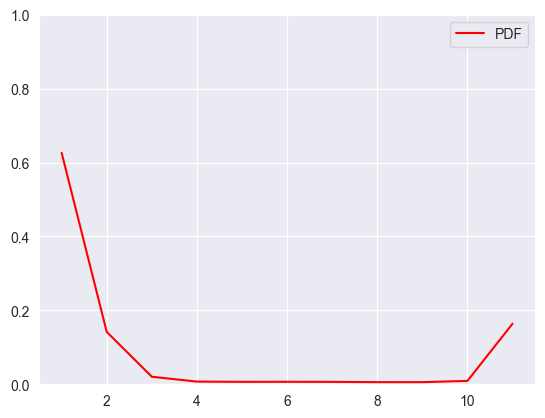

In [20]:
GraphDynPDF(LC = 1, T = 5, mF = 2, nPPL = 10, fR = .5, itr = 10000)

In [21]:
def DynItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    RDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        tRDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
        RDis = np.vstack([RDis, tRDis])
    return RDis

In [22]:
def GraphDynROut(LC, T, mF, nPPL, bl, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(0,nPPL+1)
    y = range(0,int(1/bl))

    data = DynItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Dynamic Disrobutions based on R")

    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27782.33it/s]


Stationary at 10000 iterations


100%|██████████| 100000/100000 [00:03<00:00, 28831.55it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:03<00:00, 30064.47it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 37009.06it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 36574.96it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 35393.81it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 39321.09it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 41431.48it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 37144.58it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 37653.32it/s]

Stationary at 100000 iterations


<Figure size 1000x1000 with 0 Axes>

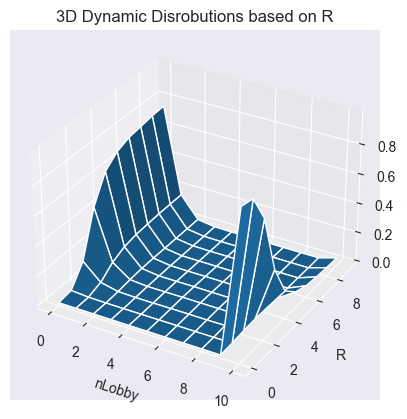

In [23]:
GraphDynROut(LC = 1, T = 5, mF = 2, nPPL = 10, bl = .1, itr = 10000)

In [172]:
def sc(nL, nC, nPPL, fR, T, mF):
    return ( (5 * nPPL * fR) + (T * nL) + ((mF * nC) ** 2) - ((mF + T) * nC) )

In [41]:
def asc(fR, LC, T, mF, nPPL, itr):
    LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    cost = sc(nL = sum(LobH) / len(LobH), nC = sum(CatH) / len(CatH), T = T, mF = mF, nPPL = nPPL, fR = fR)
    return cost

In [31]:
def CostItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    listcost = [asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        listcost.append(asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr))
    return listcost

In [145]:
def MFItr(LC, T, nPPL, itr, step, bl):
    mF = step
    listMF = [CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)]
    for i in range(2,int(10+1)):
        mF = i * step
        listMF.append(CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr))
    return listMF

In [149]:
def GraphMFitr(LC, T, nPPL, bl, step, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(int(bl*nPPL),nPPL+1)
    y = range(1,10+1)

    data = MFItr(LC = LC, T = T, nPPL = nPPL, itr = itr, bl = bl, step = step)
    minMF = data.index(min(data))
    minR = data[minMF].index(min(data[minMF]))
    data = np.array(data)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('R')
    ha.set_ylabel('mF')
    ha.set_zlabel('Average Social Cost')
    ha.set_title(f"Minimum Avg. Social Cost: mf = {(minMF+1)*step:.2f}, R = {(minR+1)*(100*bl)}%")

    plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 44531.76it/s]


<Figure size 1000x1000 with 0 Axes>

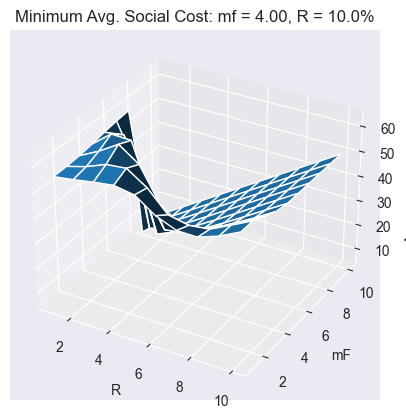

In [175]:
GraphMFitr(LC = 1, T = 5, nPPL = 10, bl = .1, step = .5, itr = 10000)

100%|██████████| 10000/10000 [00:00<00:00, 42562.93it/s]


Text(0.5, 1.0, 'The minimum avg. social cost (32.60) accures at R = 55.0%')

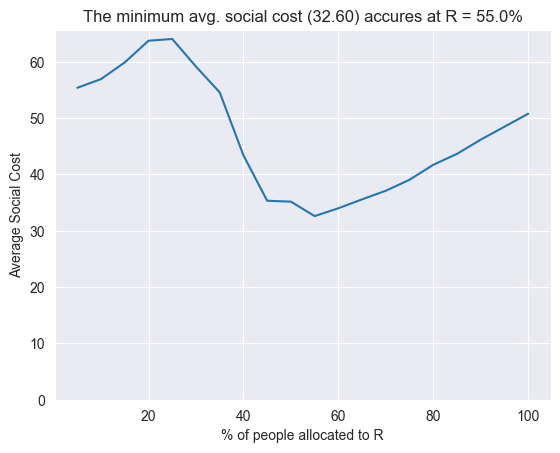

In [174]:
bl = .05
listcost = CostItrR(LC = 1, T = 5, mF = 2, nPPL = 10, bl = bl, itr = 10000)
plt.plot(range(int(100*bl),101, int(100*bl)), listcost)
plt.ylim(bottom = 0)
plt.ylabel("Average Social Cost")
plt.xlabel("% of people allocated to R")
plt.title(f"The minimum avg. social cost ({min(listcost):.2f}) accures at R = {(listcost.index(min(listcost))+1)*(100*bl)}%")